Michael Muschitiello // Beta-Neutral Trading Strategy

- This notebook explores two different methodologies for constructing and backtesting a beta‐neutral trading strategy:

1. **Annual Rebalance, Beta on Weekly Returns**  
   - Downloads daily price data for a set of long tickers (e.g. the “Magnificent 7” + IWM) and one short ticker (SPY).  
   - Computes weekly log returns for each asset to estimate a rolling exponential‐weighted beta against SPY.  
   - Rebalances the portfolio annually based on the latest weekly beta estimates, then applies hedged returns day‐to‐day.  
   - Plots and computes final performance including cumulative returns, annualized return, Sharpe ratio, and maximum drawdown.  

2. **Traditional Long‐Short/Short‐Long (LS/SL)**  
   - Demonstrates a similar annual rebalance approach but focuses on a single long/short pair (e.g. long IWM, short SPY).  
   - Computes daily returns, estimates beta on a weekly schedule, and applies hedging on daily timescales.  

## Key Steps
- **Data Acquisition**: Uses yfinance to fetch historical price data from 2020–2024.  
- **Return Computations**:  
  - Daily returns for backtesting.  
  - Weekly returns for beta estimation (via exponential weighted regression).  
- **Backtest Loop**:  
  - Identifies annual rebalance dates from weekly data.  
  - For each period, calculates average beta across the chosen long tickers relative to SPY.  
  - Applies hedging logic to form beta‐neutral daily returns.  
- **Performance Metrics**:  
  - Annualized standard deviation, Sharpe ratio, and maximum drawdown (computed via a utility function).  
  - Cumulative returns are compared across the hedged portfolio, the unhedged long portfolio, and the short SPY position.  

- By the end, this notebook offers a practical demonstration of how to integrate both daily and weekly timescales in a beta‐neutral framework, providing a thorough set of performance outputs and annualized metrics.


In [1]:
import numpy as np 
import pandas as pd 
import yfinance as yf 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
def compute_beta_neutral_metrics(returns, freq=252, risk_free_rate=0.04):
    """
    Given a series of beta-neutral portfolio returns, this function computes:
    1) Annualized standard deviation
    2) Sharpe ratio
    3) Maximum drawdown

    Args:
        returns (pd.Series): Portfolio returns (usually daily or weekly)
        freq (int): Number of periods in a year (252 for daily, 52 for weekly)
        risk_free_rate (float): Annual risk-free rate

    Returns:
        dict: Dictionary with keys 'std', 'sharpe_ratio', 'max_drawdown'
    """
    import numpy as np
    import pandas as pd

    # clean
    returns = returns.dropna()

    # annualized std
    std_annual = returns.std() * (freq**0.5)

    # annualized mean return
    mean_return_annual = returns.mean() * freq

    # Sharpe Ratio
    # (Annualized Mean Return - Risk-Free Rate) / Annualized Std Dev
    sharpe_ratio = (mean_return_annual - risk_free_rate) / std_annual if std_annual != 0 else float('nan')

    # max drawdown
    # compute cumulative returns, running maximum, and drawdown
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdowns = (cum_returns - running_max) / running_max
    max_drawdown = drawdowns.min()

    return {
        "std": std_annual,
        "sharpe_ratio": sharpe_ratio,
        "max_drawdown": max_drawdown
    }

### Annual Rebalance, Backtest on Daily, beta on weekly

[*********************100%***********************]  9 of 9 completed


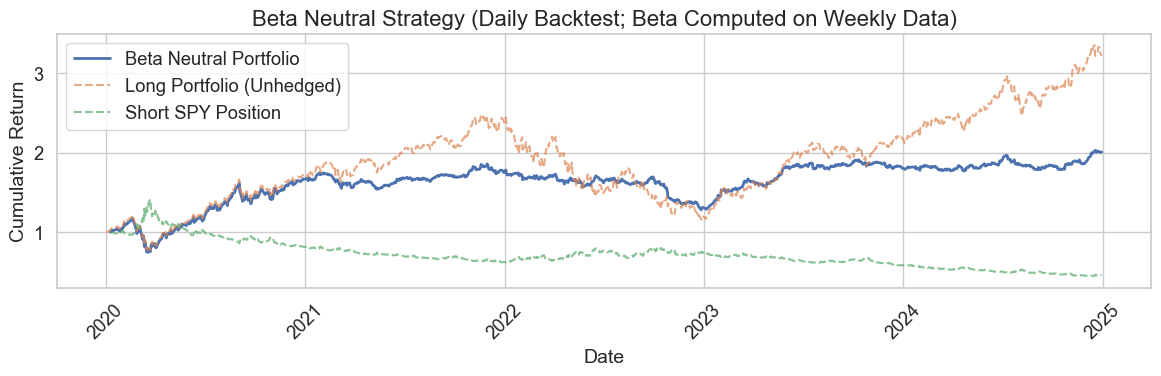

In [3]:
# NOTE: ANNUAL REBALANCE, BACKTEST ON DAILY, BETA ON WEEKLY

# define long and short positions
long_tickers = ['IWM', 'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'NVDA', 'TSLA']  # Long positions(eq weighted)
short_ticker = 'SPY'  # Short position for SPX
tickers = long_tickers + [short_ticker]

start_date = "2020-01-01"
end_date   = "2024-12-31"

data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

# exctract close prices into a single DataFrame
prices = pd.DataFrame()
for t in tickers:
    prices[t] = data[t]['Close']

# compute daily returns for backtest 
daily_returns = np.log(prices / prices.shift(1)).dropna()

# compute weekly rets for beta calculation
prices_weekly = prices.resample('W-FRI').last().dropna()
weekly_returns = np.log(prices_weekly / prices_weekly.shift(1)).dropna()

# function for ewm beta
def ewm_beta(asset_series, market_series, span=12):
    cov_ewm = asset_series.ewm(span=span).cov(market_series)
    var_ewm = market_series.ewm(span=span).var()
    beta_ewm = cov_ewm / var_ewm
    return beta_ewm

# annual rebalancing setup (based on weekly data
rebalance_dates = weekly_returns.groupby(weekly_returns.index.year, group_keys=True).apply(lambda df: df.index.min())
rebalance_dates = rebalance_dates.sort_values()

# We'll store the beta-neutral portfolio returns and the short SPY returns on a daily frequency.
portfolio_returns = pd.Series(index=daily_returns.index, dtype=float)
short_returns = pd.Series(index=daily_returns.index, dtype=float)

# backtesting loop
# For each rebalance period, compute beta using weekly returns and then apply that hedge ratio to daily returns.
weekly_span = 12  # Use 12 weeks (about 3 months) for the EWM beta calculation

for i in range(len(rebalance_dates)):
    # rebalance date is taken from weekly returns
    rebalance_date = rebalance_dates.iloc[i]
    
    if i < len(rebalance_dates) - 1:
        next_rebalance_date = rebalance_dates.iloc[i+1]
    else:
        next_rebalance_date = daily_returns.index[-1]
    
    # beta estimation 
    # Use all weekly data up to the rebalance date for beta estimation.
    weekly_slice = weekly_returns.loc[:rebalance_date]
    
    betas_current = {}
    for t in long_tickers:
        asset_series = weekly_slice[t].dropna()
        market_series = weekly_slice[short_ticker].dropna()
        if len(asset_series) < 2:
            betas_current[t] = 0.0
        else:
            ewm_b = ewm_beta(asset_series, market_series, span=weekly_span)
            betas_current[t] = ewm_b.dropna().iloc[-1] if not ewm_b.dropna().empty else 0.0

    # average beta (equal weighting) for long positions
    avg_beta_long = np.mean(list(betas_current.values()))
    
    # apply hedge
    # Map the current rebalance period to daily returns.
    daily_slice = daily_returns.loc[rebalance_date:next_rebalance_date]
    
    # compute the long portfolio daily return (equal weighted among the long tickers)
    long_port_slice = daily_slice[long_tickers].mean(axis=1)
    spx_slice = daily_slice[short_ticker]
    
    # beta-neutral daily return: long return minus hedge (avg_beta_long * SPY daily return)
    slice_portfolio_returns = long_port_slice - (avg_beta_long * spx_slice)
    portfolio_returns.loc[slice_portfolio_returns.index] = slice_portfolio_returns
    

    # NOTE: The short position is a short of SPY, not a short of the beta-weighted SPY return.
    # For the short SPY position, record the negative of (avg_beta_long * SPY daily return)
    #slice_short_returns = -(avg_beta_long * spx_slice)
    #short_returns.loc[slice_short_returns.index] = slice_short_returns
    
    # Short SPX position earns exactly -SPX returns (no beta weighting)
    slice_short_returns = -spx_slice
    short_returns.loc[slice_short_returns.index] = slice_short_returns

# cumulative performance on daily data
cumulative_portfolio = (1 + portfolio_returns).cumprod()
cumulative_long = (1 + daily_returns[long_tickers].mean(axis=1)).cumprod()
cumulative_short = (1 + short_returns).cumprod()

# plot
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 4))

plt.plot(cumulative_portfolio, label="Beta Neutral Portfolio", linewidth=2)
plt.plot(cumulative_long, label="Long Portfolio (Unhedged)", linestyle="--", alpha=0.7)
plt.plot(cumulative_short, label="Short SPY Position", linestyle="--", alpha=0.7)

plt.title("Beta Neutral Strategy (Daily Backtest; Beta Computed on Weekly Data)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Cumulative Return", fontsize=14)
plt.legend(loc="best")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [4]:
# num years in backtest sample
start_date = cumulative_portfolio.index[0]
end_date = cumulative_portfolio.index[-1]
num_days = (end_date - start_date).days
num_years = num_days / 365.25  # approximate

# pull final cumulative values
final_portfolio_value = cumulative_portfolio.iloc[-1]
final_long_value = cumulative_long.iloc[-1]
final_short_value = cumulative_short.iloc[-1]

# compute annualized rets
def annualize_cumulative(final_value, years):
    return final_value ** (1 / years) - 1

annualized_portfolio = annualize_cumulative(final_portfolio_value, num_years)
annualized_long = annualize_cumulative(final_long_value, num_years)
annualized_short = annualize_cumulative(final_short_value, num_years)

metrics = compute_beta_neutral_metrics(portfolio_returns, freq=252, risk_free_rate=0.03)
print(metrics)
print("Annualized Returns Over Entire Backtest Period:")
print(f"Beta-Neutral Portfolio: {annualized_portfolio:.2%}")
print(f"Long Portfolio        : {annualized_long:.2%}")
print(f"Short Position        : {annualized_short:.2%}")

{'std': 0.22154556348718632, 'sharpe_ratio': 0.6102251688285941, 'max_drawdown': -0.36606807253144763}
Annualized Returns Over Entire Backtest Period:
Beta-Neutral Portfolio: 14.98%
Long Portfolio        : 26.37%
Short Position        : -14.37%


### Annual Rebalance, Traditional LS/SL

[*********************100%***********************]  2 of 2 completed


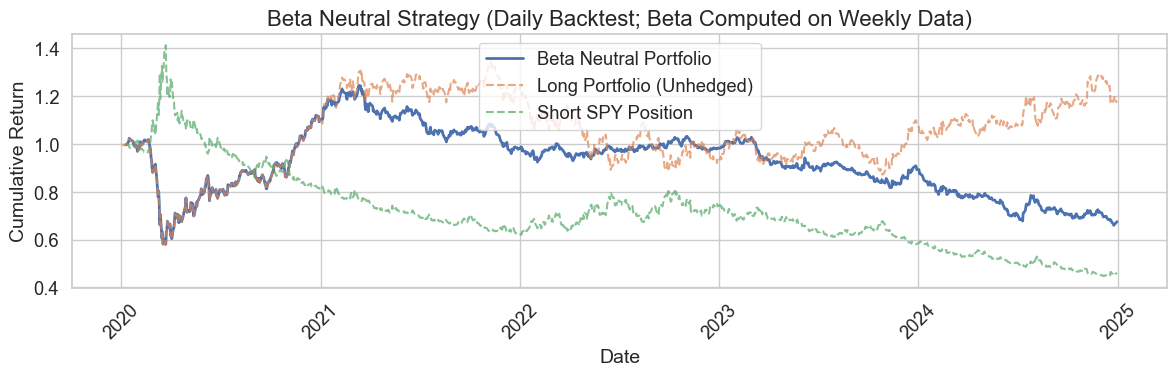

In [ ]:
# define positions
long_tickers = ['IWM']  # Long position for Russell 2000
short_ticker = 'SPY'  # Short position for SPX
tickers = long_tickers + [short_ticker]

start_date = "2020-01-01"
end_date   = "2024-12-31"

data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

# extract close prices into a single DataFrame
prices = pd.DataFrame()
for t in tickers:
    prices[t] = data[t]['Close']

# compute daily returns (for backtesting performance)
daily_returns = np.log(prices / prices.shift(1)).dropna()

# compute weekly returns (for beta estimation)
prices_weekly = prices.resample('W-FRI').last().dropna()
weekly_returns = np.log(prices_weekly / prices_weekly.shift(1)).dropna()


# annual rebalancing setup (based on weekly data)
rebalance_dates = weekly_returns.groupby(weekly_returns.index.year, group_keys=True).apply(lambda df: df.index.min())
rebalance_dates = rebalance_dates.sort_values()

# store the beta-neutral portfolio returns and the short SPY returns on a daily frequency.
portfolio_returns = pd.Series(index=daily_returns.index, dtype=float)
short_returns = pd.Series(index=daily_returns.index, dtype=float)

# backtesting loop
# For each rebalance period, compute beta using weekly returns and then apply that hedge ratio to daily returns.
weekly_span = 12  # Use 12 weeks for the EWM beta calculation

for i in range(len(rebalance_dates)):
    # Rebalance date is taken from weekly returns
    rebalance_date = rebalance_dates.iloc[i]
    
    # Determine next rebalance date 
    if i < len(rebalance_dates) - 1:
        next_rebalance_date = rebalance_dates.iloc[i+1]
    else:
        next_rebalance_date = daily_returns.index[-1]
    
    # Beta Estimation 
    # Use all weekly data up to the rebalance date for beta estimation.
    weekly_slice = weekly_returns.loc[:rebalance_date]
    
    betas_current = {}
    for t in long_tickers:
        asset_series = weekly_slice[t].dropna()
        market_series = weekly_slice[short_ticker].dropna()
        if len(asset_series) < 2:
            betas_current[t] = 0.0
        else:
            ewm_b = ewm_beta(asset_series, market_series, span=weekly_span)
            betas_current[t] = ewm_b.dropna().iloc[-1] if not ewm_b.dropna().empty else 0.0

    # average beta for long positions
    avg_beta_long = np.mean(list(betas_current.values()))
    
    # apply beta hedge to daily returns
    # Map the current rebalance period to daily returns.
    daily_slice = daily_returns.loc[rebalance_date:next_rebalance_date]
    
    # compute the long portfolio daily return 
    long_port_slice = daily_slice[long_tickers].mean(axis=1)
    spx_slice = daily_slice[short_ticker]
    
    # beta-neutral daily return: long return minus hedge (avg_beta_long * SPY daily return)
    slice_portfolio_returns = long_port_slice - (avg_beta_long * spx_slice)
    portfolio_returns.loc[slice_portfolio_returns.index] = slice_portfolio_returns
    
    # For the short SPY position, record the negative of (avg_beta_long * SPY daily return)
    #slice_short_returns = -(avg_beta_long * spx_slice)
    #short_returns.loc[slice_short_returns.index] = slice_short_returns

    # Short SPX position earns exactly -SPX returns (no beta weighting)
    slice_short_returns = -spx_slice
    short_returns.loc[slice_short_returns.index] = slice_short_returns

# cumulative performance on daily data
cumulative_portfolio = (1 + portfolio_returns).cumprod()
cumulative_long = (1 + daily_returns[long_tickers].mean(axis=1)).cumprod()
cumulative_short = (1 + short_returns).cumprod()

# plot the results
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 4))

plt.plot(cumulative_portfolio, label="Beta Neutral Portfolio", linewidth=2)
plt.plot(cumulative_long, label="Long Portfolio (Unhedged)", linestyle="--", alpha=0.7)
plt.plot(cumulative_short, label="Short SPY Position", linestyle="--", alpha=0.7)

plt.title("Beta Neutral Strategy (Daily Backtest; Beta Computed on Weekly Data)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Cumulative Return", fontsize=14)
plt.legend(loc="best")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# num years in backtest sample
start_date = cumulative_portfolio.index[0]
end_date = cumulative_portfolio.index[-1]
num_days = (end_date - start_date).days
num_years = num_days / 365.25  # approximate

# pull final cumulative values
final_portfolio_value = cumulative_portfolio.iloc[-1]
final_long_value = cumulative_long.iloc[-1]
final_short_value = cumulative_short.iloc[-1]

annualized_portfolio = annualize_cumulative(final_portfolio_value, num_years)
annualized_long = annualize_cumulative(final_long_value, num_years)
annualized_short = annualize_cumulative(final_short_value, num_years)

metrics = compute_beta_neutral_metrics(portfolio_returns, freq=252, risk_free_rate=0.03)
print(metrics)
print("Annualized Returns Over Entire Backtest Period:")
print(f"Beta-Neutral Portfolio: {annualized_portfolio:.2%}")
print(f"Long Portfolio        : {annualized_long:.2%}")
print(f"Short Position        : {annualized_short:.2%}")

{'std': 0.21954326845912242, 'sharpe_ratio': -0.3853306235717184, 'max_drawdown': -0.4701914464926338}
Annualized Returns Over Entire Backtest Period:
Beta-Neutral Portfolio: -7.56%
Long Portfolio        : 3.25%
Short Position        : -14.37%
